# Faster Computations with Numba

## Some notes mostly for myself, but could be useful to you

Altough Python is fast compared to other high-level languages, it still is not as fast as C, C++ or Fortran. Luckily, two open source projects [Numba](http://numba.pydata.org/) and [Cython](http://cython.org/) can be used to speed-up computations. [Numba](http://numba.pydata.org/) is sponsored by the producer of [Anaconda](https://store.continuum.io/cshop/anaconda/), [Continuum Analytics](http://continuum.io/). Both projects allow you to convert your code to interpreted language so that it runs faster. Here I will use Numba, given its ease and Just-In-Time nature, although I still have to figure out how to save and use the compiled functions (newer versions of [Numba](http://numba.pydata.org/) seem to have introduced [Ahead-of-Time](https://numba.pydata.org/numba-doc/dev/user/pycc.html) compilation using pycc and static libraries it seems.). Cython on the other hand needs you to understand much more of C and Ctypes. But once you figure out a way to run your code and compile it, you have a library ready to use and import. See the code for the repository for my paper [Optimal consumption under uncertainty, liquidity constraints, and bounded rationality](http://ozak.github.io/BoundedConsumption/) where I used Cython for the dynsysf.pyx function.

# Numba

Numba is quite easy to use. Start by importing it

    import numba as nb

or some of its functions

    from numba import jit, autojit, njit
    
Then define your function and notate it using the Numba commands jit, njit, autojit or their decorators @jit, @njit.

In [1]:
from numba import jit, njit, autojit, jitclass
import numba as nb
import math
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', nb.errors.NumbaDeprecationWarning)

## Examples:

In [2]:
# A simple function that computes the maximum distance between two vectors
@nb.jit('f8(f8[:],f8[:])')
def errnb(V0,V1):
    maxi=0.0
    for i in range(V0.shape[0]):
        m = abs(V1[i]-V0[i])
        if m>=maxi:
            maxi = m
    return maxi

x = np.random.random((1000))
y = np.random.random((1000))

%timeit errnb(x,y)
%timeit np.max(np.abs(x-y))

2.37 µs ± 231 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.19 µs ± 304 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [3]:
# Let's use Numba to compute a Cobb-Douglas function
@jit
def CobbDouglas(K, L, A, alpha, beta):
    return A * K**alpha * L**beta

K, L, A, alpha, beta = 2, 2, 1, .3, .7

CobbDouglas(K,L,A,alpha,beta)

2.0

Let's time it and compare with Numpy or simple Python

In [4]:
%timeit A * K**alpha * L**beta

147 ns ± 2.49 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [5]:
%timeit CobbDouglas(K,L,A,alpha,beta)

225 ns ± 12.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Well not fast enough...why?

In [6]:
CobbDouglas.inspect_types()

CobbDouglas (int64, int64, int64, float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-3-3e653c7a0b0c>
# --- LINE 2 --- 
# label 0

@jit

# --- LINE 3 --- 

def CobbDouglas(K, L, A, alpha, beta):

    # --- LINE 4 --- 
    #   K = arg(0, name=K)  :: int64
    #   L = arg(1, name=L)  :: int64
    #   A = arg(2, name=A)  :: int64
    #   alpha = arg(3, name=alpha)  :: float64
    #   beta = arg(4, name=beta)  :: float64
    #   $0.4 = K ** alpha  :: float64
    #   del alpha
    #   del K
    #   $0.5 = A * $0.4  :: float64
    #   del A
    #   del $0.4
    #   $0.8 = L ** beta  :: float64
    #   del beta
    #   del L
    #   $0.9 = $0.5 * $0.8  :: float64
    #   del $0.8
    #   del $0.5
    #   $0.10 = cast(value=$0.9)  :: float64
    #   del $0.9
    #   return $0.10

    return A * K**alpha * L**beta




OK...it is correctly compiled and it is using Numba types and not PyObjects. So perhaps we cannot gain much in this simple computation...but that is ok. Let's try something a little more complex, computing a CobbDouglas for vectors K and L

In [7]:
# Python function
def CobbDouglas(K, L, A, alpha, beta):
    return A * K**alpha * L**beta

CobbDouglas_nb = jit(CobbDouglas)
CobbDouglas_nb2 = njit(CobbDouglas)

In [8]:
K = np.random.random((100,1))
L = np.random.random((100,1))

In [9]:
%timeit CobbDouglas(K,L,A,alpha,beta)

7.52 µs ± 575 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%timeit CobbDouglas_nb(K,L,A,alpha,beta)

4.7 µs ± 59.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
%timeit CobbDouglas_nb2(K,L,A,alpha,beta)

5.94 µs ± 621 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Ooops what went wrong? Up to V.0.12.2 Numba could not create arrays in ``njit`` mode, i.e. without using Python Objects. But things seem to have improved a lot since then. But even for the old days, we do not need to despair, we can create a fast CobbDouglas function by iterating over our vectors. Here I first create the `CobbDouglasNB` function which takes floating point numbers and tells Numba not to use PyObjects, and then I create the vectorized version `CobbDouglasVecNB`, which iterates over the elements of K and L (here we assume both are vectors) and returns our output Y. I know it is strange that we have to give the output as part of the function, but it allows us to speed up the computations.

In [12]:
@nb.njit('f8(f8, f8, f8, f8, f8)')
def CobbDouglasNB(K, L, A, alpha, beta):
    return A * K**alpha * L**beta

@nb.jit('f8[:](f8[:], f8[:], f8[:], f8, f8, f8)')
def CobbDouglasVecNB(Y, K, L, A, alpha, beta):
    for i in range(K.shape[0]):
        Y[i]=CobbDouglasNB(K[i],L[i],A,alpha,beta)
    return Y

In [13]:
K.mean()

0.48966064683582006

In [14]:
%timeit CobbDouglas(K[:,0],L[:,0],A,alpha,beta)

9.17 µs ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
Y=np.zeros_like(K)
%timeit CobbDouglasVecNB(Y[:,0],K[:,0],L[:,0],A,alpha,beta)

6.46 µs ± 157 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Almost twice as fast as Numpy!

Let's generalize the function to arrays of 2 dimensions

In [16]:
@nb.jit('f8[:,:](f8[:,:], f8[:,:], f8[:,:], f8, f8, f8)')
def CobbDouglasVecNB(Y, K, L, A, alpha, beta):
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            Y[i,j]=CobbDouglasNB(K[i,j], L[i,j], A, alpha, beta)
    return Y

In [17]:
K=np.random.random((1000,1000))
L=np.random.random((1000,1000))
%timeit CobbDouglas(K,L,A,alpha,beta)

48.9 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
Y=np.zeros_like(K)
%timeit CobbDouglasVecNB(Y,K,L,A,alpha,beta)

44 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 20% faster than Numpy...so we get the idea.

While this is great to speed up, we see that there are some issues one has to think about in order to get those gains.

Now let's use the vectorize option, which creates Numpy Ufunctions, that is functions that operate on vectors (or at leats that s what I gather).

In [19]:
@nb.vectorize('f8(f8, f8, f8, f8, f8,)')
def CobbDouglasNB2(K, L, A, alpha, beta):
    return A * K**alpha * L**beta

In [20]:
%timeit CobbDouglasNB2(K,L,A,alpha,beta)

45.4 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's compare these functions on different sizes of matrices $K$ and $L$

In [21]:
K = np.random.random((10000, 10000))
L = np.random.random((10000, 10000))
Y = np.zeros_like(K)

In [22]:
%timeit CobbDouglas(K[1:100,1:100],L[1:100,1:100],A,alpha,beta)

478 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%timeit CobbDouglasVecNB(Y[1:100,1:100],K[1:100,1:100],L[1:100,1:100],A,alpha,beta)

450 µs ± 9.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%timeit CobbDouglasNB2(K[1:100,1:100],L[1:100,1:100],A,alpha,beta)

428 µs ± 40.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
%timeit CobbDouglas(K[1:1000,1:1000],L[1:1000,1:1000],A,alpha,beta)

40.4 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit CobbDouglasVecNB(Y[1:1000,1:1000],K[1:1000,1:1000],L[1:1000,1:1000],A,alpha,beta)

37.1 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit CobbDouglasNB2(K[1:1000,1:1000],L[1:1000,1:1000],A,alpha,beta)

39 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now let's try the CRRA utility function

In [28]:
@nb.jit('f8(f8, f8)')
def U_numba(c, sigma):
    '''This function returns the value of utility when the CRRA
    coefficient is sigma. I.e. 
    u(c,sigma)=(c**(1-sigma)-1)/(1-sigma) if sigma!=1 
    and 
    u(c,sigma)=ln(c) if sigma==1
    Usage: u(c,sigma)
    '''
    if sigma!=1:
        u = (c**(1-sigma)-1)/(1-sigma)
    else:
        u = math.log(c)
    return u

In [29]:
@nb.jit('f8[:](f8[:], f8[:], f8)')
def Uvec(u,c,sigma):
    if sigma!=1:
        for i in range(c.shape[0]):
            u[i] = U_numba(c[i], sigma)
    else:
        u = np.log(c)
    return u

In [30]:
def Unp(c,sigma):
    if sigma!=1:
        u=(c**(1-sigma)-1)/(1-sigma)
    else:
        u=np.log(c)
    return u

In [31]:
@nb.vectorize('f8(f8,f8)')
def Unb(c,sigma):
    if sigma!=1:
        u = (c**(1-sigma)-1)/(1-sigma)
    else:
        u = math.log(c)
    return u

In [32]:
@nb.jit('f8[:](f8[:], f8)')
def U(c, sigma):
    if sigma!=1:
        u = Unb(c,sigma)#(c**(1-sigma)-1)/(1-sigma)
    else:
        u = np.log(c)
    return u

In [33]:
# Grid of values for state variable over which function will be approximated
gridmin, gridmax, gridsize = 0.1, 5, 300
grid = np.linspace(gridmin, gridmax**1e-1, gridsize)**10

In [34]:
%timeit U(grid,1)

2.49 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
%timeit Unp(grid,1)

2.45 µs ± 63.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
%timeit Unb(grid,1)

2.71 µs ± 152 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [37]:
u = np.zeros_like(grid)
%timeit Uvec(u, grid, 1)

2.42 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
%timeit U(grid,3)

5.93 µs ± 327 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
%timeit Unb(grid,3)

6.33 µs ± 58.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [40]:
%timeit Unp(grid,3)

8.68 µs ± 43.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [41]:
u = np.zeros_like(grid)
%timeit Uvec(u,grid,3)

5.73 µs ± 162 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Optimizing the code for Dynamic Programming

## Optimal Growth

In [42]:
# Parameters Optimal Growth
alpha = .3
beta = .9
sigma = 1
delta = 1
A = 1

In [43]:
# Grid of values for state variable over which function will be approximated
gridmin, gridmax, gridsize = 0.1, 5, 300
grid = np.linspace(gridmin, gridmax**1e-1, gridsize)**10

# Parameters for the optimization procedures
count=0
maxiter=1000
tol=1e-6
print('tol=%f' % tol)
print(grid.shape)

tol=0.000001
(300,)


In [44]:
import numba as nb
from scipy.optimize import fminbound
from scipy import interp

# Auxiliary functions 
# Maximize function V on interval [a,b]
def maximum(V, a, b, args=[]):
    return float(V(fminbound(lambda x: -V(x), a, b,args=args)))

# Return Maximizer of function V on interval [a,b]
def maximizer(V, a, b, args=[]):
    return float(fminbound(lambda x: -V(x), a, b, args=args))

# Interpolation functions Class
class LinInterp:
    "Provides linear interpolation in one dimension."

    def __init__(self, X, Y):
        """Parameters: X and Y are sequences or arrays
        containing the (x,y) interpolation points.
        """
        self.X, self.Y = X, Y

    def __call__(self, z):
        """Parameters: z is a number, sequence or array.
        This method makes an instance f of LinInterp callable,
        so f(z) returns the interpolation value(s) at z.
        """
        if isinstance(z, int) or isinstance(z, float):
            return interp ([z], self.X, self.Y)[0]
        else:
            return interp(z, self.X, self.Y)

In [45]:
@nb.jit('f8[:](f8[:], f8)')
def U(c,sigma):
    if sigma!=1:
        u = Unb(c,sigma)
    else:
        u = np.log(c)
    return u

@nb.vectorize('f8(f8,f8)')
def Unb(c,sigma):
    if sigma!=1:
        u = (c**(1-sigma)-1)/(1-sigma)
    else:
        u = math.log(c)
    return u

In [46]:
@nb.vectorize('f8(f8, f8, f8, f8, f8,)')
def CobbDouglasNB2(K, L, A, alpha, beta):
    '''CobbDouglasNB2(K, L, A, alpha, beta)'''
    return A * K**alpha * L**beta

@nb.vectorize('f8(f8, f8, f8)')
def F_nb(K, alpha, A):
    '''
    Cobb-Douglas production function
    F(K)=A* K^alpha
    '''
    return A * K**alpha

def F_np(K, alpha, A):
    '''
    Cobb-Douglas production function
    F(K)=A* K^alpha
    '''
    return A * K**alpha

In [47]:
%timeit CobbDouglasNB2(grid,1,A,alpha,0)

9.68 µs ± 382 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [48]:
%timeit F_nb(grid,alpha,A)

7.28 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [49]:
%timeit F_np(grid,alpha,A)

7.6 µs ± 538 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [50]:
V0 = LinInterp(grid,U(grid,sigma))

In [51]:
def bellman(x,w):
    """The approximate Bellman operator.
    Parameters: w is a LinInterp object (i.e., a 
    callable object which acts pointwise on arrays).
    Returns: An instance of LinInterp that represents the optimal operator.
    w is a function defined on the state space.
    """
    vals = []
    for k in x:
        kmax=F_nb(k,alpha,A)
        h = lambda kp: U_numba(kmax + (1-delta) * k - kp,sigma) + beta * w(kp)
        vals.append(maximum(h, 0, kmax))
    return LinInterp(grid, vals)

In [52]:
def policy(x,w):
    """
    For each function w, policy(w) returns the function that maximizes the 
    RHS of the Bellman operator.
    Replace w for the Value function to get optimal policy.
    The approximate optimal policy operator w-greedy (See Stachurski (2009)). 
    Parameters: w is a LinInterp object (i.e., a 
    callable object which acts pointwise on arrays).
    Returns: An instance of LinInterp that captures the optimal policy.
    """
    vals = []
    for k in x:
        kmax=F_nb(k,alpha,A)
        h = lambda kp: U_numba(kmax + (1-delta) * k - kp, sigma) + beta * w(kp)
        vals.append(maximizer(h, 0, kmax))
    return LinInterp(grid, vals)

In [53]:
def solve():
    count=0
    V0=LinInterp(grid,U(grid,sigma))
    while count<maxiter:
        V1 = bellman(grid,V0)
        err = np.max(np.abs(np.array(V1(grid))-np.array(V0(grid))))
        V0 = V1
        count += 1
        if err<tol:
            print(count)
            break
    return V0

In [54]:
V0 = bellman(grid, V0)
C0 = policy(grid, V0)

In [55]:
%timeit bellman(grid, V0)
%timeit policy(grid ,V0)
%timeit solve()

182 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
193 ms ± 9.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
138
138
138
138
138
138
138
138
22.1 s ± 267 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
def Utrf(kp,kmax,k,sigma,w):
    return -U_numba(kmax + (1-delta) * k - kp,sigma)-beta*w(kp)

@nb.jit('f8[:](f8[:], f8[:])')
def bellmannb(x,w0):
    """The approximate Bellman operator.
    Parameters: w is a LinInterp object (i.e., a 
    callable object which acts pointwise on arrays).
    Returns: An instance of LinInterp that represents the optimal operator.
    w is a function defined on the state space.
    """
    w = LinInterp(x,w0)
    vals = np.array([])
    for k in x:
        kmax = F_nb(k,alpha,A)
        vals = np.append(vals, -Utrf(fminbound(Utrf, 0, kmax, args=[kmax,k,sigma,w]),kmax,k,sigma,w))
    return vals

@nb.jit('f8[:](f8[:],f8[:])')
def policynb(x,w0):
    """The approximate Bellman operator.
    Parameters: w is a LinInterp object (i.e., a 
    callable object which acts pointwise on arrays).
    Returns: An instance of LinInterp that represents the optimal operator.
    w is a function defined on the state space.
    """
    w = LinInterp(x,w0)
    vals = np.array([])
    for k in x:
        kmax = F_nb(k,alpha,A)
        vals = np.append(vals,fminbound(Utrf, 0, kmax, args=[kmax,k,sigma,w]))
    return vals

@nb.jit('f8(f8[:],f8[:])')
def errnb(V0,V1):
    maxi=0.0
    for i in range(V0.shape[0]):
        m=abs(V1[i]-V0[i])
        if m>=maxi:
            maxi=m
    return maxi

@nb.jit('f8[:]()')
def solvenb():
    count=0.0
    V0=U(grid,sigma)
    while count<maxiter:
        V1=bellmannb(grid,V0)
        err=errnb(V1,V0)
        V0=V1
        count+=1
        if err<tol:
            print(count)
            break
    return V0

<ipython-input-56-b9b01bd2fa01>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bellmannb" failed type inference due to: Untyped global name 'LinInterp': cannot determine Numba type of <class 'type'>

File "<ipython-input-56-b9b01bd2fa01>", line 12:
def bellmannb(x,w0):
    <source elided>
    """
    w = LinInterp(x,w0)
    ^

  @nb.jit('f8[:](f8[:], f8[:])')
<ipython-input-56-b9b01bd2fa01>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "bellmannb" failed type inference due to: Untyped global name 'LinInterp': cannot determine Numba type of <class 'type'>

File "<ipython-input-56-b9b01bd2fa01>", line 12:
def bellmannb(x,w0):
    <source elided>
    """
    w = LinInterp(x,w0)
    ^

  @nb.jit('f8[:](f8[:], f8[:])')
/Users/ozak/anaconda3/envs/GeoPython36env/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning: Function "bellmannb" was compiled in object mode wit

In [57]:
U0 = U(grid, sigma)

U0 = bellmannb(grid, U0)

c0 = policynb(grid, U0)

<ipython-input-56-b9b01bd2fa01>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "bellmannb" failed type inference due to: Untyped global name 'Utrf': cannot determine Numba type of <class 'function'>

File "<ipython-input-56-b9b01bd2fa01>", line 16:
def bellmannb(x,w0):
    <source elided>
        kmax = F_nb(k,alpha,A)
        vals = np.append(vals, -Utrf(fminbound(Utrf, 0, kmax, args=[kmax,k,sigma,w]),kmax,k,sigma,w))
        ^

  @nb.jit('f8[:](f8[:], f8[:])')
/Users/ozak/anaconda3/envs/GeoPython36env/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning: Function "bellmannb" was compiled in object mode without forceobj=True.

File "<ipython-input-56-b9b01bd2fa01>", line 14:
def bellmannb(x,w0):
    <source elided>
    vals = np.array([])
    for k in x:
    ^

  self.func_ir.loc))
/Users/ozak/anaconda3/envs/GeoPython36env/lib/python3.6/site-packages/numba/compiler.py:751: NumbaDeprecationWarning: 
Fall-back from th

In [58]:
%timeit bellmannb(grid, U0)
%timeit policynb(grid, U0)
%timeit solvenb()

130 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
127 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<ipython-input-56-b9b01bd2fa01>:43: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "solvenb" failed type inference due to: Invalid use of type(CPUDispatcher(<function bellmannb at 0x1b7a36950>)) with parameters (readonly array(float64, 1d, C), array(float64, 1d, C))
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function bellmannb at 0x1b7a36950>))
[2] During: typing of call at <ipython-input-56-b9b01bd2fa01> (48)


File "<ipython-input-56-b9b01bd2fa01>", line 48:
def solvenb():
    <source elided>
    while count<maxiter:
        V1=bellmannb(grid,V0)
        ^

  @nb.jit('f8[:]()')
/Users/ozak/anaconda3/envs/GeoPython36env/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning: Function "solvenb" was compiled in object mode without forceobj=True.

File "<ipython-input-56-b9b01bd2fa01>", line 46:
def solvenb():
    <source elided>
    count=0.0
    V0=U(grid,sigma)
    ^

  self.func_ir.loc))
/Us

138.0
138.0
138.0
138.0
138.0
138.0
138.0
138.0
16.6 s ± 688 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


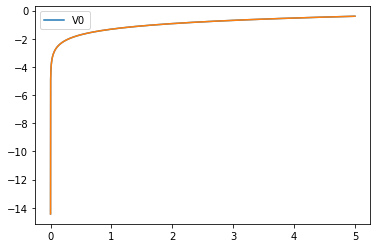

In [59]:
plt.plot(grid, V0(grid), label='V0')
plt.plot(grid, U0)
plt.legend()

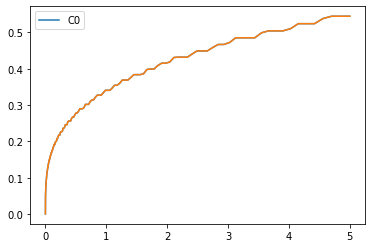

In [60]:
plt.plot(grid, C0(grid), label='C0')
plt.plot(grid, c0)
plt.legend()

In [61]:
@nb.jit('f8(f8[:], f8[:])')
def errnb(V0, V1):
    maxi=0.0
    for i in range(V0.shape[0]):
        m=abs(V1[i]-V0[i])
        if m>=maxi:
            maxi=m
    return maxi

@nb.jit('f8[:]()')
def solvenb():
    count=0.0
    V0 = U(grid,sigma)
    while count<maxiter:
        V1 = bellmannb(grid, V0)
        err = errnb(V1, V0)
        V0 = V1
        count += 1
        if err<tol:
            print(count)
            break
    return V0
%timeit solvenb()

<ipython-input-61-dfc6052a5170>:10: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "solvenb" failed type inference due to: Invalid use of type(CPUDispatcher(<function U at 0x1b7876d08>)) with parameters (readonly array(float64, 1d, C), Literal[int](1))
Known signatures:
 * (array(float64, 1d, A), float64) -> array(float64, 1d, A)
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function U at 0x1b7876d08>))
[2] During: typing of call at <ipython-input-61-dfc6052a5170> (13)


File "<ipython-input-61-dfc6052a5170>", line 13:
def solvenb():
    <source elided>
    count=0.0
    V0 = U(grid,sigma)
    ^

  @nb.jit('f8[:]()')
<ipython-input-61-dfc6052a5170>:10: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "solvenb" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-61-dfc6052a5170>", line 13

138.0
138.0
138.0
138.0
138.0
138.0
138.0
138.0
16.2 s ± 72.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
